# Partial Dependenceによる特徴の増加減と予測結果の変化の可視化

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# データセットの取得

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris['feature_names']
target_names = iris.target_names

print("データセット内容の種類")
print(iris.keys())
print("特徴量の種類")
print(iris['feature_names'])
print("ラベルの種類")
print(target_names)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ', y_test.shape)

データセット内容の種類
dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
特徴量の種類
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
ラベルの種類
['setosa' 'versicolor' 'virginica']
X_train.shape =  (120, 4)
y_train.shape =  (120,)
X_test.shape =  (30, 4)
y_test.shape =  (30,)


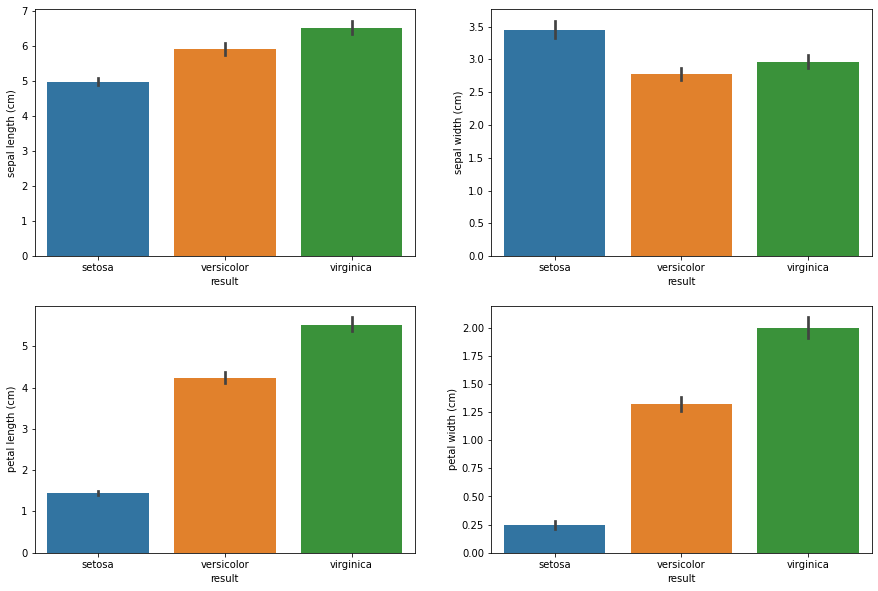

In [3]:
X_train_dataframe = pd.DataFrame(X_train, columns=iris.feature_names)

y_label = []
for i in y_train:
    y_label.append(target_names[i])
y_train_dataframe = pd.DataFrame(y_label, columns=['result'])

train_dataframe = pd.concat([X_train_dataframe, y_train_dataframe], axis=1)

import seaborn as sns

fig = plt.figure(figsize=[15,10])
for i, f in enumerate(iris['feature_names']):
    fig.add_subplot(2, 2, i+1)
    sns.barplot(y=f, x='result', data= train_dataframe)

# モデルの学習と評価

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = sklearn.ensemble.RandomForestClassifier(n_estimators=2, max_depth = 3, random_state=2)
model.fit(X_train, y_train)

accuracy_score(y_test, model.predict(X_test))

0.9666666666666667

# Partial Dependenceによる特徴の増加減と予測結果の変化の可視化

c:\users\naolu\documents\github\xai_samples\.venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
c:\users\naolu\documents\github\xai_samples\.venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
c:\users\naolu\documents\github\xai_samples\.venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings

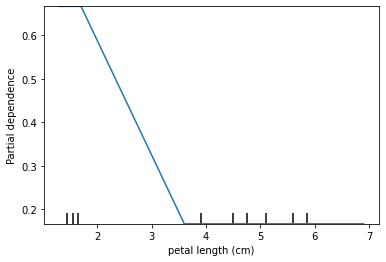

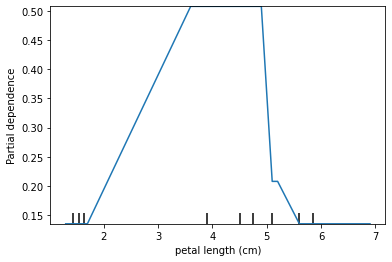

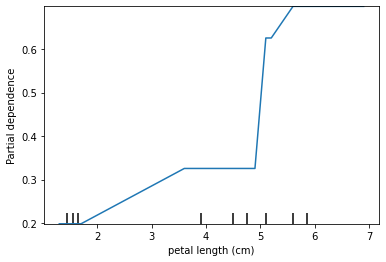

In [5]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

for i in range(len(target_names)):
    plot_partial_dependence(estimator=model,
                             X=X_test,
                             features=['petal length (cm)'],
                             feature_names=feature_names,
                             target=i,#ターゲット名
                             kind='average')


# Partial Dependence手法の実装

In [6]:
from dataclasses import dataclass
from typing import Any
from __future__ import annotations

@dataclass
class PartialDependence:
    """Partial Dependence (PD)

    Args:
        estimator: 学習済みモデル
        X: 特徴量
        var_names: 特徴量の名前
    """
    
    estimator: Any
    X: np.ndarray
    var_names: list[str]
    
    def _counterfactual_prediction(
        self,
        idx_to_replace: int,
        value_to_replace: float
    ) -> np.ndarray:
        """ある特徴量の値を置き換えたときの予測値を求める

        Args:
            idx_to_replace: 値を置き換える特徴量のインデックス
            value_to_replace: 置き換える値
        """

        # 特徴量の値を置き換える際、元データが上書きされないようコピー
        X_replaced = self.X.copy()

        # 特徴量の値を置き換えて予測
        X_replaced[:, idx_to_replace] = value_to_replace
        y_pred = self.estimator.predict(X_replaced)

        return y_pred

    def partial_dependence(
        self,
        var_name: str,
        n_grid: int = 50
    ) -> None:
        """PDを求める

        Args:
            var_name: 
                PDを計算したい特徴量の名前
            n_grid: 
                グリッドを何分割するか
                細かすぎると値が荒れるが、粗すぎるとうまく関係を捉えられない
                デフォルトは50
        """
        
        # 可視化の際に用いるのでターゲットの変数名を保存
        self.target_var_name = var_name  
        # 変数名に対応するインデックスをもってくる
        var_index = self.var_names.index(var_name)

        # ターゲットの変数を、取りうる値の最大値から最小値まで動かせるようにする
        value_range = np.linspace(
            self.X[:, var_index].min(), 
            self.X[:, var_index].max(), 
            num=n_grid
        )

        # インスタンスごとのモデルの予測値を平均
        average_prediction = np.array([
            self._counterfactual_prediction(var_index, x).mean()
            for x in value_range
        ])

        # データフレームとしてまとめる
        self.df_partial_dependence = pd.DataFrame(
            data={var_name: value_range, "avg_pred": average_prediction}
        )
        
    def plot(self, ylim: list[float] | None = None) -> None:
        """PDを可視化

        Args:
            ylim: 
                Y軸の範囲
                特に指定しなければavg_predictionの範囲となる
                異なる特徴量のPDを比較したいときなどに指定する
        """

        fig, ax = plt.subplots()
        ax.plot(
            self.df_partial_dependence[self.target_var_name],
            self.df_partial_dependence["avg_pred"],
        )
        ax.set(
            xlabel=self.target_var_name,
            ylabel="Average Prediction",
            ylim=ylim
        )
        fig.suptitle(f"Partial Dependence Plot ({self.target_var_name})")
        
        fig.show()

C:\Users\naolu\AppData\Local\Temp/ipykernel_6556/794648350.py:101: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


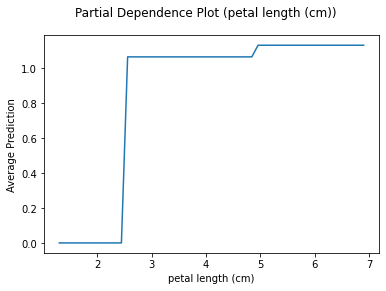

In [7]:
pdp = PartialDependence(model, X_test, feature_names)
pdp.partial_dependence('petal length (cm)', n_grid=50)

pdp.plot()